In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
from skimage import filters, color
import os
import cv2
import random
import tqdm.auto as tqdm
from functools import partial
import csv
from PIL import Image, ImageDraw


In [11]:
DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

USE_CACHE = False
PLOT_RESULTS = False
SEED = 2
random.seed(SEED)

### ANALISIS

In [12]:
from matplotlib import colors


def scatter_plot_rgb(imag, axs=None):
    r, g, b = cv2.split(imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1, 1, 1, projection="3d")

    axs.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Red")
    axs.set_ylabel("Green")
    axs.set_zlabel("Blue")
    axs.set_title("RGB Scatter Plot")
    plt.show()

def scatter_plot_hsv(imag, axs=None):
    hsv_imag = cv2.cvtColor(imag, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1, 1, 1, projection="3d")

    axs.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Hue")
    axs.set_ylabel("Saturation")
    axs.set_zlabel("Value")
    axs.set_title("HSV Scatter Plot")
    plt.show()
    return hsv_imag


### MEDIDAS

In [13]:
def image_covering(image, mask):
    """
    This function computes the covering of the image by the mask
    indice de jaccard
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    union = np.sum(np.where(image + mask > 0, 1, 0))
    return intersection / union

def image_matching(image, mask):
    """
    This function computes the matching of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    return intersection / np.sum(np.where(mask > 0, 1, 0))

def jaccard_index(imagen_referencia, imagen_segmentacion):
    # Convertir las imágenes a arreglos NumPy binarios
    referencia_binaria = np.asarray(imagen_referencia).astype(bool)
    segmentacion_binaria = np.asarray(imagen_segmentacion).astype(bool)

    # Calcular el tamaño de la intersección y la unión
    interseccion = np.logical_and(referencia_binaria, segmentacion_binaria)
    union = np.logical_or(referencia_binaria, segmentacion_binaria)

    # Calcular el índice de Jaccard
    jaccard = np.sum(interseccion) / np.sum(union)

    return jaccard

### SEGMENTADORES

In [112]:
class pipeline:
    def __init__(self) -> None:
        self.operations = []
    
    def __repr__(self):
        operation_names = [op.__name__ for op in self.operations][::-1]
        par = [')' for _ in range(len(self.operations) - 1)]
        return f"ImageProcessingPipeline: {'('.join(operation_names)}(image{''.join(par)})"

    def add_operation(self, operation):
        self.operations.append(operation)
    
    def remove_operation(self, operation):
        self.operations.remove(operation)
    
    def apply(self, image, verbose=False):
        img = image.copy()
        if verbose:
            #print(str(self))
            plt.figure()
            plt.title("Original")
            plt.imshow(img)
            plt.show()
        for operation in tqdm.tqdm(self.operations, desc="Processing", unit="operation",disable=True):
            img = operation(img)
            if(verbose):
                plt.figure()
                #plt.title(operation.__name__)
                plt.imshow(img)
                plt.show()
        return img


def otsu_threshold(image):
    gray = color.rgb2gray(np.array(image))
    threshold = filters.threshold_otsu(gray)
    return gray > threshold

def adaptive_threshold(gray_image):
    return cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)


def kmeans_segmentation(image, k = 3):
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    return segmented_image

def kmeans_segmentation2(image, k = 3):
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    res = [image]
    for i in range(k):
        temp = np.zeros(centers.shape, np.uint8)
        temp[i] = centers[i]
        res.append((temp[labels.flatten()]).reshape((image.shape)))
    return res, centers

def keep_most_blue_component(kmeans_results, Print=False):
    res, _ = kmeans_results
    blue_mask = keep_blue(res[0]) > 0
    max_jaccard = 0
    for i in range(1, len(res)):
        jaccard = jaccard_index(blue_mask, res[i])
        if jaccard > max_jaccard:
            max_jaccard = jaccard
            blue_mask_res = res[i]
    if(Print):
        plt.imshow(blue_mask_res)
        plt.title("Blue mask result")
        plt.show()
    return blue_mask_res
        

def morfology_cleaning(image):
    cleaned = morphology.remove_small_objects(image, min_size=200)
    return cleaned


# def adaptive_threshold(image):
#     """
#     This function applies adaptive thresholding to the image

#     returns the binary image
#     """
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                    cv2.THRESH_BINARY, 11, 2)
#     return binary > 0

def keep_blue(image, Print=False):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([90,50,50])
    upper_blue = np.array([250,255,255])

    # blue color mask
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    res = cv2.bitwise_and(image,image, mask= mask)

    if(Print):
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax1.imshow(image_rgb)
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(mask)
        ax3 = fig.add_subplot(1, 3, 3)
        res_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        ax3.imshow(res_rgb)
    return res

def canny_edge_detection(image):
    gray = image#cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    return edges# > 0

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)



def print_metrics(binary):
    # Label the largest object in the image
    labels = measure.label(binary)
    largest_object = np.argmax(np.bincount(labels.flat)[1:]) + 1

    # Create a mask 
    pool_mask = labels == largest_object

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]
    area = prop.area  
    perimeter = prop.perimeter  

    # Eccentricity of the ellipse equivalent to the region. This is the ratio of the distance between the foci of the ellipse 
    # and its major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.
    eccentricity = prop.eccentricity
    equivalent_diameter = prop.equivalent_diameter  # in pixels

    print( "Area: ", area)
    print( "Perimeter: ", perimeter)
    print( "Eccentricity: ", eccentricity)
    print( "Equivalent Diameter: ", equivalent_diameter)

def display_image_mask(image, mask, title=None):
    if title:
        print()
        print(title)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].matshow(image)
    axs[1].matshow(mask, cmap='gray')
    axs[0].set_title("Original")
    axs[1].set_title("Processed")
    plt.axis('off')
    plt.show()

def interpolate_image_size(image, prop_size, interpolation):
    ''' 
    Increase/decrease the size of the image by a given proportion, using the given interpolation method
    '''
    height, width = (image.shape[:2])
    return cv2.resize(image, (int(width), int(height)), interpolation=interpolation)

def obtain_measured_mask(img_name, results_path, mask_shape):
    '''
    This function obtains the mask of the image with the given name from the results path
    '''
    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:
            if row['filename'] == img_name:
                region_attr = eval(row["region_shape_attributes"])
                mask_verts = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))

                mask = Image.new("RGB", mask_shape, "black")
                mask_draw = ImageDraw.Draw(mask)
                mask_draw.polygon(mask_verts, outline="white", fill="white")
                mask = cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY)
                
                return mask


ANALISIS ESPACIO COLOR

A continuacion se observa:

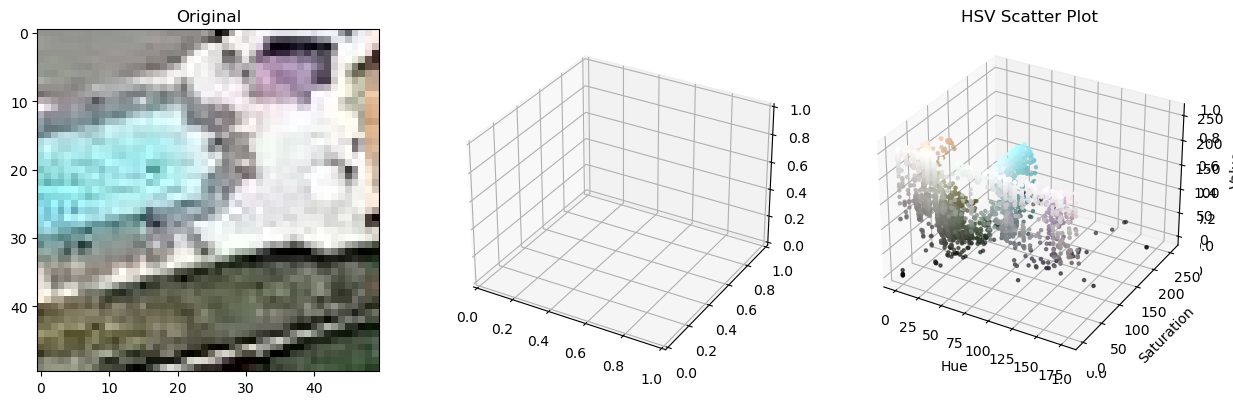

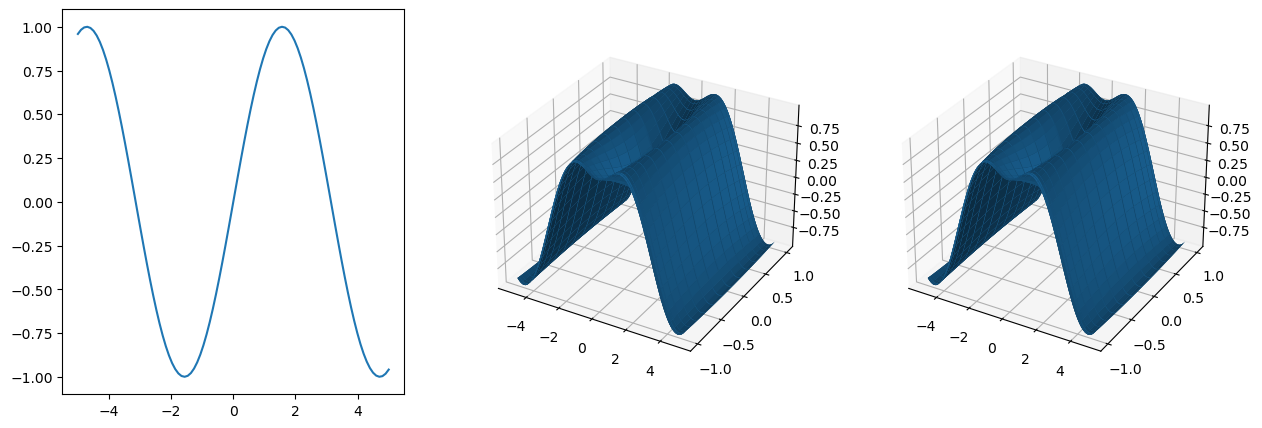

In [15]:

images = ['img16.jpg']


for image_name in images:
    imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', image_name))
    image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)

    # Create a new figure
    fig = plt.figure(figsize=(15, 5))

    # Create a 2D subplot
    ax1 = fig.add_subplot(1, 3, 1)

    # Create first 3D subplot
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')

    # Create second 3D subplot
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')

    ax1.imshow(image_rgb)
    ax1.set_title("Original")
    ax2 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_plot_hsv(image_rgb, ax2)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_plot_rgb(image_rgb, ax3)

# scatter_plot_rgb(image_rgb)
# image_hsv = scatter_plot_hsv(image_rgb)


# light_blue = (157, 200, 255)
# dark_blue = (0, 110, 255)

# pipe1 = pipeline()
# pipe1.add_operation(partial(kmeans_segmentation,k=5))
# kmeans = pipe1.apply(image_rgb, True)

# scatter_plot_rgb(kmeans)
# kmeans_hsv = scatter_plot_hsv(kmeans)

# lo_square = np.full((10, 10, 3), light_blue, dtype=np.uint8) / 255.0
# do_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8) / 255.0

# plt.subplot(1, 2, 1)
# plt.imshow(do_square)
# plt.subplot(1, 2, 2)
# plt.imshow(lo_square)
# plt.show()

# plt.subplot(1, 2, 1)
# plt.imshow(colors.rgb_to_hsv(do_square))
# plt.subplot(1, 2, 2)
# plt.imshow(colors.rgb_to_hsv(lo_square))
# plt.show()

# mask = cv2.inRange(image_hsv, light_blue, dark_blue)
# result = cv2.bitwise_and(image_hsv, image_hsv, mask=mask)


# plt.subplot(1, 2, 1)
# plt.imshow(mask, cmap="gray")
# plt.subplot(1, 2, 2)
# plt.imshow(result)
# plt.show()


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate some example data
x = np.linspace(-5, 5, 100)
y = np.sin(x)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create a new figure
fig = plt.figure(figsize=(15, 5))

# Create a 2D subplot
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x, y)

# Create first 3D subplot
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X, Y, Z)

# Create second 3D subplot
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(X, Y, Z)

plt.show()


### Segmentadores


PIPELINE - K-means con otsu thresholding

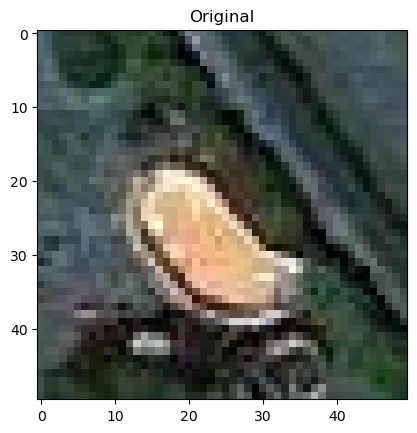

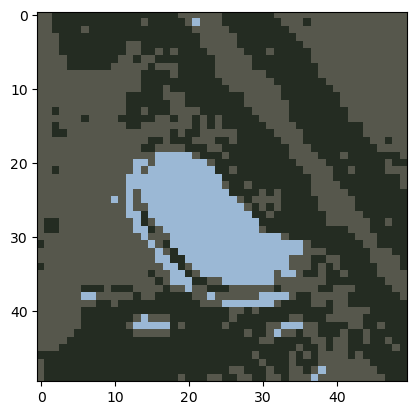

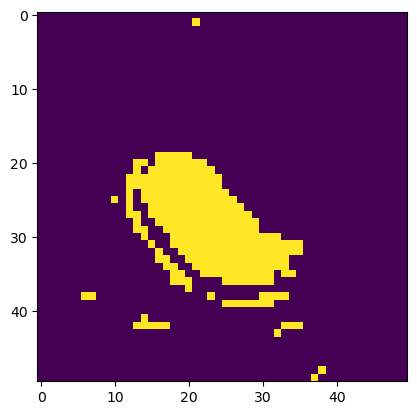


ImageProcessingPipeline: otsu_threshold(kmeans_segmentation(image))


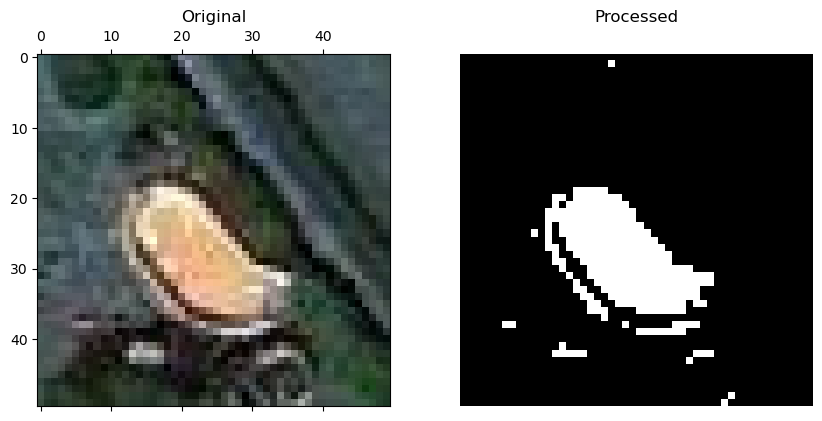

Area:  246
Perimeter:  87.18376618407356
Eccentricity:  0.8459646599585872
Equivalent Diameter:  17.697935698969246
Indice de Jaccard:  0.638095238095238
Cobertura de imagen: 0.8305785123966942


In [66]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)


pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
pipe1.add_operation(otsu_threshold)
binary = pipe1.apply(imag, True)
display_image_mask(imag, binary, title=pipe1)
print_metrics(binary)

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
mask = obtain_measured_mask('img0.jpg', results_path, gray.shape)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

En los resultados anteriores se muestra la aplicación de segmentación mediante el algoritmo K-means, con un posterior uso del método de Otsu para thresholding para seleccionar la componente deseada entre las devueltas por K-means. Se puede observar que el resultado es bastante bueno, ya que se llega a separar la piscina de forma aproximada. Se observa también que este resultado de segmentación incluye bastantes detalles no deseados, que pueden verse evaluando el índice de Jaccard obtenido.

PIPELINE - K-means con otsu thresholding y eliminación de ruido

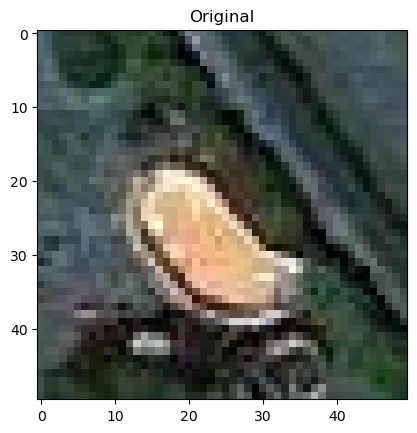

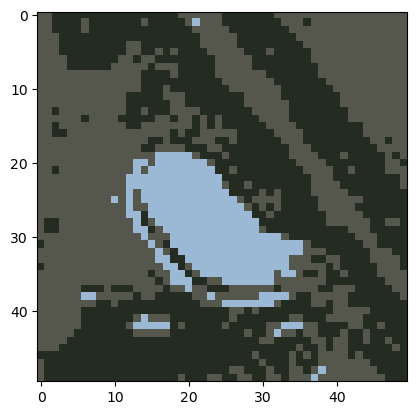

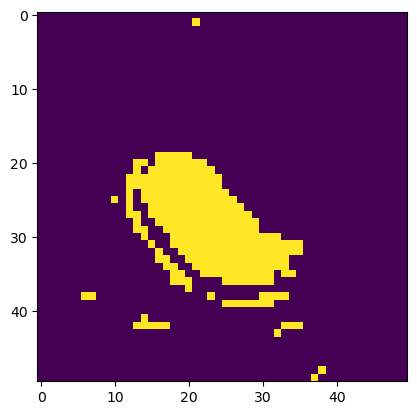

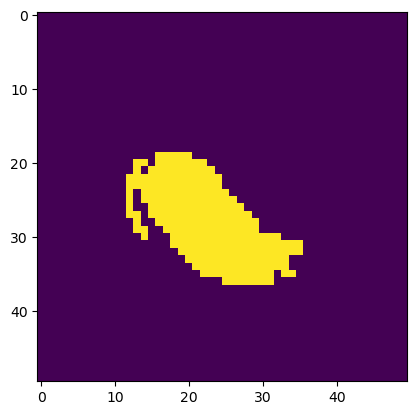


ImageProcessingPipeline: morfology_cleaning(otsu_threshold(kmeans_segmentation(image)))


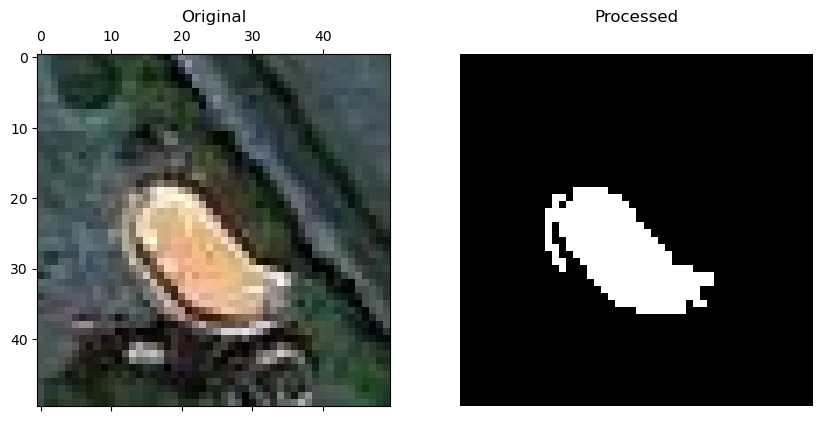

Area:  234
Perimeter:  75.35533905932738
Eccentricity:  0.886207068070585
Equivalent Diameter:  17.26088217525478
Indice de Jaccard:  0.7060931899641577
Cobertura de imagen: 0.8140495867768595


In [67]:
pipe2 = pipeline()
pipe2.add_operation(kmeans_segmentation)
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_cleaning)
binary = pipe2.apply(imag, True)

display_image_mask(imag, binary, title=pipe2)
print_metrics(binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

Al agregar un paso de eliminación de ruido, se puede observar que el resultado mejora considerablemente, ya que se eliminan los detalles no deseados. Esto se puede observar en el aumento del índice de Jaccard, así como en la propia máscara obtenida. Esto se debe a que la mayoría de los detalles no deseados son de un tamaño menor al del kernel utilizado para la eliminación de ruido mediante erosión/dilatación. Se refleja este resultado en el aumento del índice de Jaccard obtenido, que significa que se llegó a una aproximación más exacta de la imagen. A su vez, la disminución leve del indice de cobertura significa que la mayoría de los detalles eliminados no son parte de la piscina.

PIPELINE - otsu thresholding y eliminación de ruido

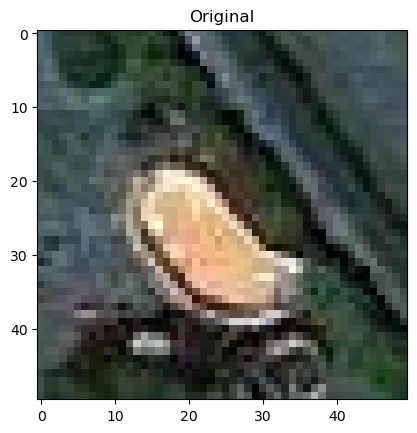

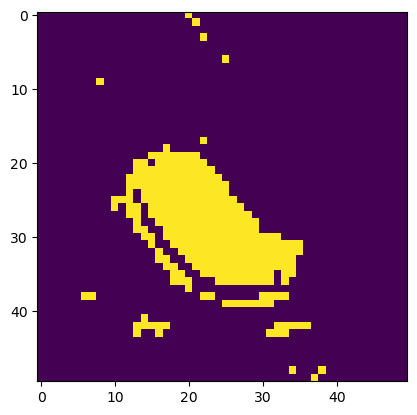

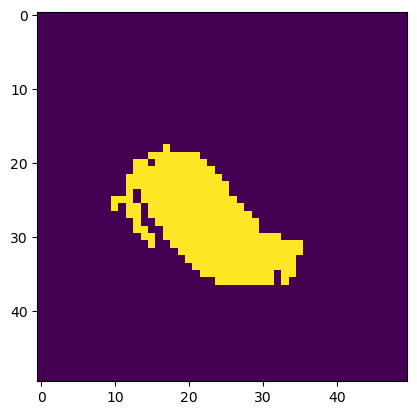

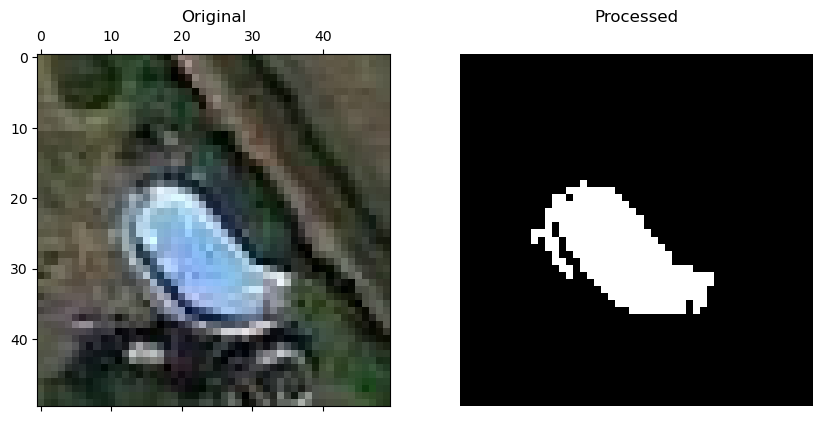

Area:  250
Perimeter:  85.42640687119284
Eccentricity:  0.8843567586196108
Equivalent Diameter:  17.841241161527712
Indice de Jaccard:  0.684931506849315
Cobertura de imagen: 0.8264462809917356


In [68]:
pipe3 = pipeline()
pipe3.add_operation(otsu_threshold)
pipe3.add_operation(morfology_cleaning)
binary = pipe3.apply(imag, True)
display_image_mask(image_rgb, binary)
print_metrics(binary)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

Al aplicar segmentación omitiendo el paso de k-means para separación de componentes, el resultado es un poco peor que en el caso anterior, ya que se pierden algunos detalles durante la separación de la piscina. Esto se refleja en una cobertura que es menos exacta en lo que refiere a ajustarse al área de la piscina, ya que no tiene en cuenta la forma de la misma obtenida por k-means en el caso anterior, disminuyendo el indice de Jaccard dado. Sin embargo, en este caso esto también termina causando que se incluyan más detalles que en el caso en que se usa k-means, lo que se puede observar en el índice de cobertura obtenido.

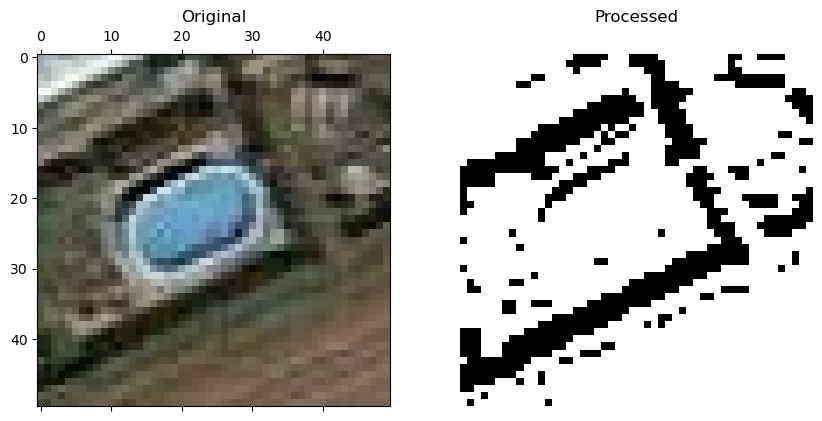

Area:  1912
Perimeter:  681.7361107568208
Eccentricity:  0.4000257374294009
Equivalent Diameter:  49.339983882583816
Indice de Jaccard:  0.10542797494780794
Cobertura de imagen: 0.9853658536585366


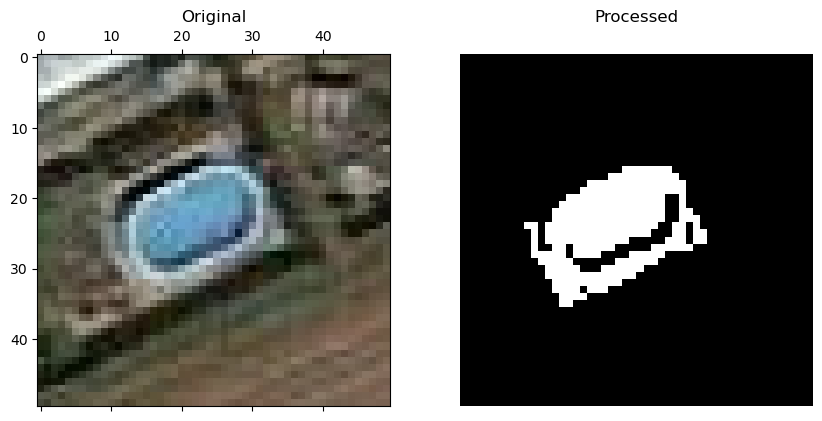

Area:  260
Perimeter:  124.32590180780451
Eccentricity:  0.780140980046302
Equivalent Diameter:  18.19456736586892
Indice de Jaccard:  0.55
Cobertura de imagen: 0.8048780487804879


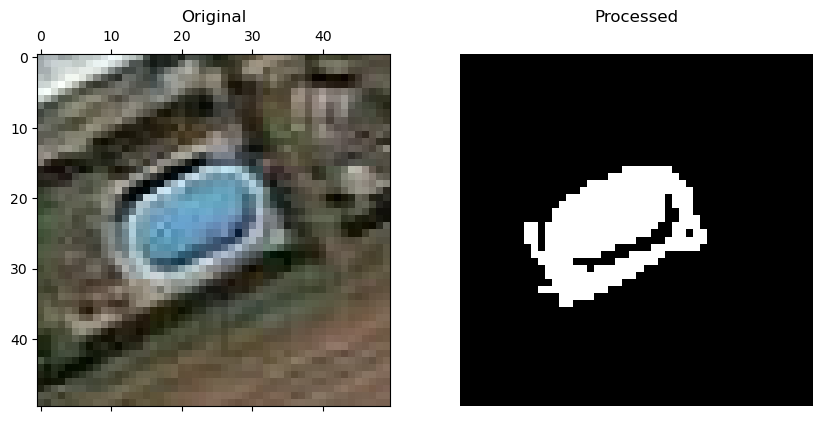

Area:  280
Perimeter:  123.15432893255071
Eccentricity:  0.7992536472263344
Equivalent Diameter:  18.881394877652593
Indice de Jaccard:  0.5594855305466238
Cobertura de imagen: 0.848780487804878


In [69]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img29.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img29.jpg', results_path, gray.shape)

binary = pipe1.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

binary = pipe2.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

binary = pipe3.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

En este caso pueden verse en orden los resultados de aplicar a una misma imagen los diferentes algoritmos de segmentación, con sus respectivos parámetros.

EXPERIMENTO SOBRE TODAS LAS IMAGENES CON MASCARA PRE CALCULADA:

In [20]:
def test_mask_results(results_path, k_try=3):

    results = []

    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:

            imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', row["filename"]))

            region_attr = eval(row["region_shape_attributes"])
            shape_teo = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))
            
            pipe = pipeline()
            pipe.add_operation(partial(kmeans_segmentation, k=k_try))
            pipe.add_operation(otsu_threshold)
            pipe.add_operation(morfology_cleaning)
            binary = pipe.apply(imag, False)

            mask_teo = Image.new("RGB", binary.shape, "black")
            dibujo_teo = ImageDraw.Draw(mask_teo)
            dibujo_teo.polygon(shape_teo, outline="white", fill="white")
            mask_teo = cv2.cvtColor(np.array(mask_teo), cv2.COLOR_RGB2GRAY)

            results.append(jaccard_index(mask_teo, binary))
    
    return results

def test_k_iterative(results_path, k_min, k_max):
    resultados = []
    for k in range(k_min, k_max):
        resultados_k = test_mask_results(results_path, k)
        print('k =', k, '| Mean =', np.mean(resultados_k), '| Std. dev =', np.array(resultados_k).std())
        
        n = len(resultados_k)
        resultados.append(resultados_k)
    
    return np.array(resultados).reshape((n, k_max - k_min))

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
test = test_k_iterative(results_path, 2, 15)

print(np.max(test), np.where(test == np.max(test)))
print(np.min(test), np.where(test == np.min(test)))

k = 2 | Mean = 0.3433435082101698 | Std. dev = 0.2467604007201795
k = 3 | Mean = 0.26313296549384363 | Std. dev = 0.22270637111912936
k = 4 | Mean = 0.28517605989048034 | Std. dev = 0.23533566489039853
k = 5 | Mean = 0.28549452064962466 | Std. dev = 0.2334513052589983
k = 6 | Mean = 0.27080870665598983 | Std. dev = 0.21696190395078618
k = 7 | Mean = 0.2520555198987161 | Std. dev = 0.210797634822538
k = 8 | Mean = 0.2933849590649739 | Std. dev = 0.24691758563785549
k = 9 | Mean = 0.3091585417690597 | Std. dev = 0.24416871130407192
k = 10 | Mean = 0.2812487814752797 | Std. dev = 0.22157074203469407
k = 11 | Mean = 0.30595179406980505 | Std. dev = 0.2451919484401486
k = 12 | Mean = 0.2722432658576046 | Std. dev = 0.24119735987772176
k = 13 | Mean = 0.30345704716559874 | Std. dev = 0.23564701199533897
k = 14 | Mean = 0.3147527846405382 | Std. dev = 0.24734781218963106
0.8740601503759399 (array([7], dtype=int64), array([10], dtype=int64))
0.0 (array([ 0,  0,  0,  4,  8,  9, 11, 12, 14, 14, 

COMENTARIO - podemos ir probando de variar kmeans, tenemos casos en los que da bien pero muchos casos en los que da mal porque kmeans agarra algo suelto en toda la imagen (ver abajo), que es lo que nos baja el promedio

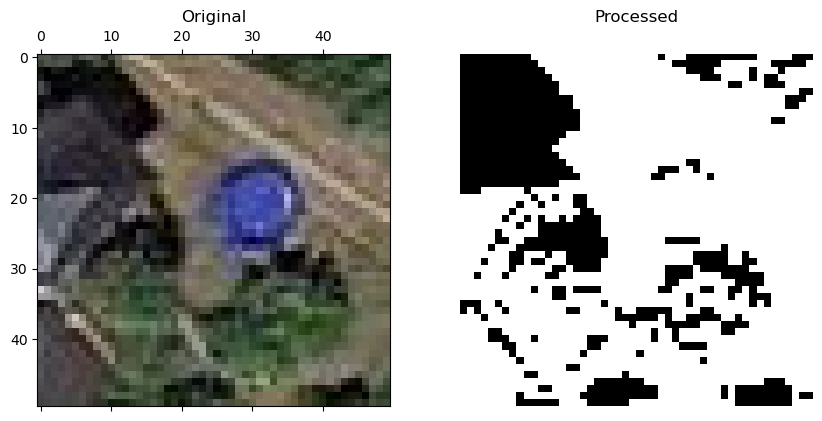

Area:  1844
Perimeter:  601.5523445727472
Eccentricity:  0.5649182566568546
Equivalent Diameter:  48.45465633447048
Indice de Jaccard:  0.07150537634408602
Cobertura de imagen: 0.8926174496644296


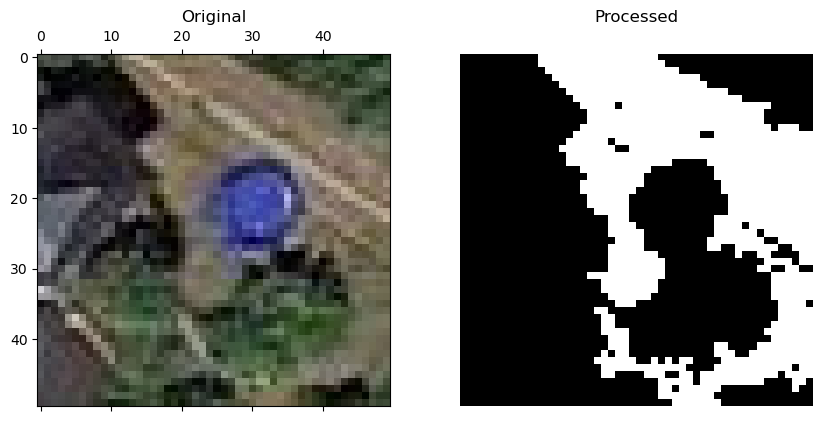

Area:  923
Perimeter:  340.97770542341357
Eccentricity:  0.7617844105370759
Equivalent Diameter:  34.28119163317628
Indice de Jaccard:  0.016113744075829384
Cobertura de imagen: 0.11409395973154363


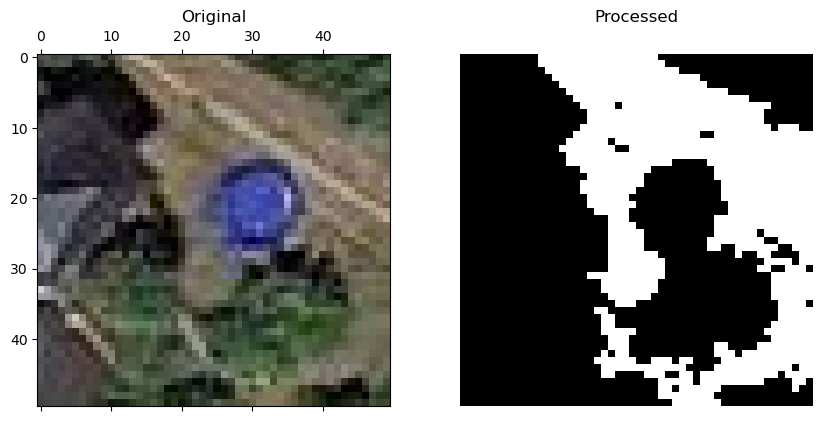

Indice de Jaccard:  0.016933207902163686
Cobertura de imagen: 0.12080536912751678


In [90]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img11.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img11.jpg', results_path, gray.shape)

binary = pipe2.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_k_7 = pipeline()
pipe_k_7.add_operation(partial(kmeans_segmentation, k=7))
pipe_k_7.add_operation(otsu_threshold)
pipe_k_7.add_operation(morfology_cleaning)
binary = pipe_k_7.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_inter_k_7 = pipeline()
pipe_inter_k_7.add_operation(partial(interpolate_image_size, prop_size=4, interpolation=cv2.INTER_CUBIC))
pipe_inter_k_7.add_operation(partial(kmeans_segmentation, k=7))
pipe_inter_k_7.add_operation(otsu_threshold)
pipe_inter_k_7.add_operation(morfology_cleaning)
binary = pipe_inter_k_7.apply(imag, False)
#binary = interpolate_image_size(binary, prop_size=0.25, interpolation=cv2.INTER_CUBIC)
display_image_mask(image_rgb, binary)
#print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

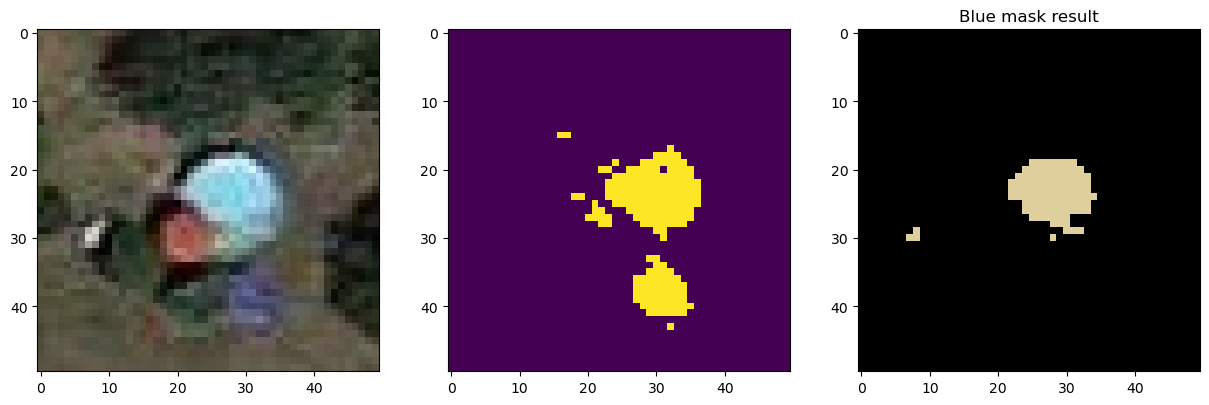

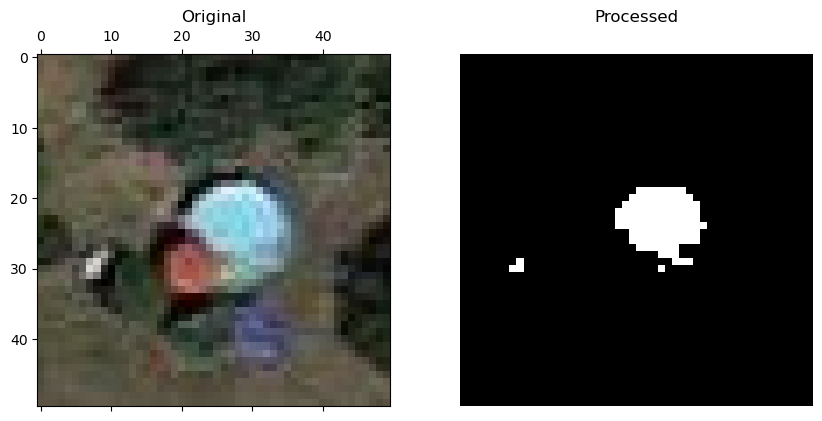

Indice de Jaccard:  0.5962732919254659
Cobertura de imagen: 0.6114649681528662


In [110]:
pipe_keep_most_blue = pipeline()
pipe_keep_most_blue.add_operation(partial(kmeans_segmentation2, k=7))
pipe_keep_most_blue.add_operation(keep_most_blue_component)
#pipe_keep_most_blue.add_operation(otsu_threshold)
pipe_keep_most_blue.add_operation(to_grayscale)
#pipe_keep_most_blue.add_operation(morfology_cleaning)
binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
#print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

In [113]:
def test_mask_results_keep_blue(results_path, k_try=3):

    results = []

    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:

            imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', row["filename"]))

            region_attr = eval(row["region_shape_attributes"])
            shape_teo = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))
            
            pipe = pipeline()
            pipe.add_operation(partial(kmeans_segmentation2, k=k_try))
            pipe.add_operation(keep_most_blue_component)
            pipe.add_operation(to_grayscale)
            binary = pipe.apply(imag, False)

            mask_teo = Image.new("RGB", binary.shape, "black")
            dibujo_teo = ImageDraw.Draw(mask_teo)
            dibujo_teo.polygon(shape_teo, outline="white", fill="white")
            mask_teo = cv2.cvtColor(np.array(mask_teo), cv2.COLOR_RGB2GRAY)

            results.append(jaccard_index(mask_teo, binary))
    
    return results

def test_k_iterative_keep_blue(results_path, k_min, k_max):
    resultados = []
    for k in range(k_min, k_max):
        resultados_k = test_mask_results_keep_blue(results_path, k)
        print('k =', k, '| Mean =', np.mean(resultados_k), '| Std. dev =', np.array(resultados_k).std())
        
        n = len(resultados_k)
        resultados.append(resultados_k)
    
    return np.array(resultados).reshape((n, k_max - k_min))

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
test = test_k_iterative_keep_blue(results_path, 2, 15)

print(np.max(test), np.where(test == np.max(test)))
print(np.min(test), np.where(test == np.min(test)))

k = 2 | Mean = 0.10942207395088678 | Std. dev = 0.1509925553476683
k = 3 | Mean = 0.08346554249638616 | Std. dev = 0.1305734124434449
k = 4 | Mean = 0.08597895692085998 | Std. dev = 0.1498452154371398
k = 5 | Mean = 0.03512448997500206 | Std. dev = 0.046549610187256917
k = 6 | Mean = 0.03234830772581792 | Std. dev = 0.05209812753022388
k = 7 | Mean = 0.017162193853616756 | Std. dev = 0.02128828633211747
k = 8 | Mean = 0.01535468255444575 | Std. dev = 0.026607434655368013
k = 9 | Mean = 0.011920386013067908 | Std. dev = 0.026620803751614446
k = 10 | Mean = 0.011943586757043212 | Std. dev = 0.025208103740831652
k = 11 | Mean = 0.0109285538757315 | Std. dev = 0.03420217892812983
k = 12 | Mean = 0.006862693055259721 | Std. dev = 0.014898229423283173
k = 13 | Mean = 0.0030675055993361275 | Std. dev = 0.005183257404174193
k = 14 | Mean = 0.004793268516322241 | Std. dev = 0.014231221460323384
0.6105527638190955 (array([1], dtype=int64), array([9], dtype=int64))
0.0 (array([ 5,  7,  7, 10, 10,

En el caso anterior probe interpolar para agrandar la imagen antes de segmentar, no parece tener resultados positivos.

Pero también hay casos en que al aumentar k no devuelve nada por como estamos decidiendo que componente usar

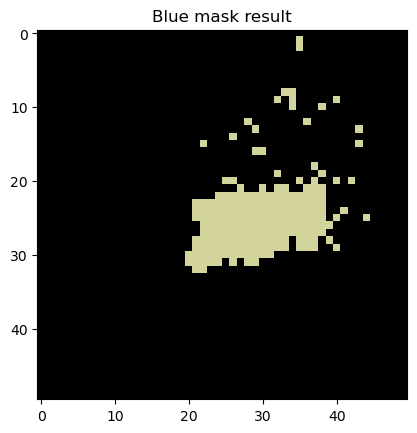

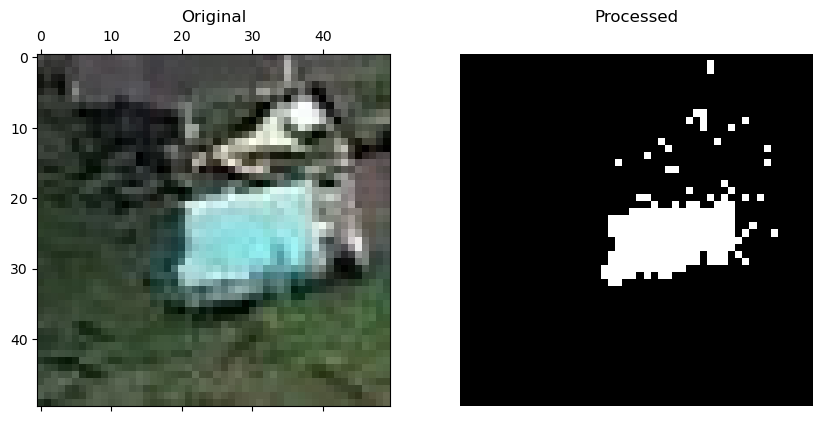

Area:  175
Perimeter:  61.14823227814083
Eccentricity:  0.8594957431558684
Equivalent Diameter:  14.927053303604616
Indice de Jaccard:  0.6028880866425993
Cobertura de imagen: 0.6761133603238867


In [114]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img5.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img5.jpg', results_path, gray.shape)

binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

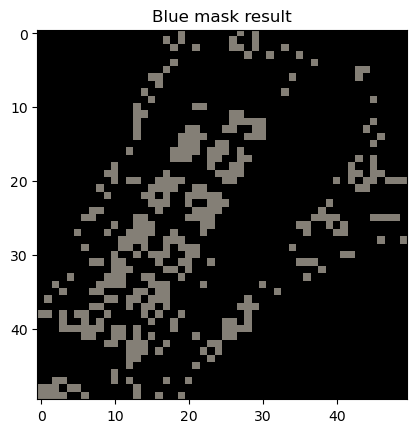

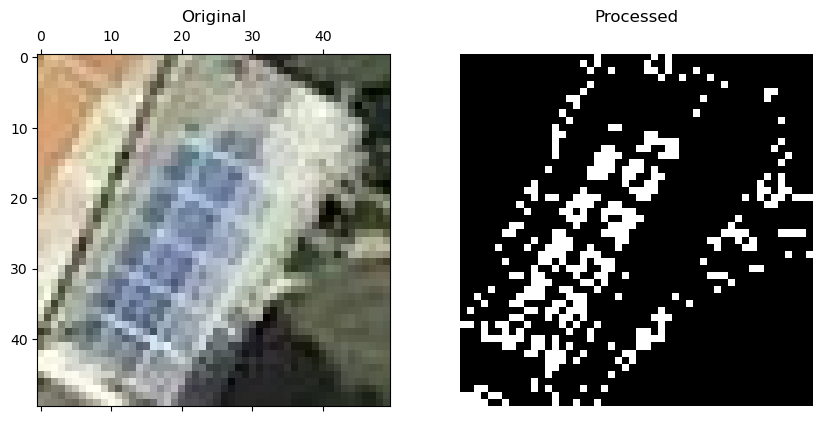

Area:  71
Perimeter:  68.73401871576773
Eccentricity:  0.9200318825559218
Equivalent Diameter:  9.507891862878783
Indice de Jaccard:  0.23325892857142858
Cobertura de imagen: 0.2801608579088472


In [115]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img15.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img15.jpg', results_path, gray.shape)

binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

EXPERIMENTOS EXTRA/

- generar mascaras con los varios segmentadores y hallar la interseccion de ellas, ver si mejora.
- variar k en k-means
- variar el tamaño del kernel en la eliminacion de ruido (parametros de morfology cleaning)
- interpolar antes de segmentar para aumentar tamaño de la imagen

In [ ]:
DETERMINAR FORMA DE LA PISCINA/ EXTRAER CARACTERISTICAS, COMENTARLAS, FORMA, AREA, DEFINIR PRESICION ETC.



COMENTAR PROBLEMAS, DIFICULTADES, ETC (agregar ejemplos si vale la pena)